In [1]:
# ## Import Required Libraries
import numpy as np
import tensorflow as tf

# Configure GPU before any other TensorFlow operations
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory limit to 90% of available GPU memory
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*9)]  # 90% of 1024MB
        )
        print("GPU is available and configured")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout, LayerNormalization, MultiHeadAttention, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pickle
import os
import re
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


2025-05-01 19:54:29.634714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746129269.850603      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746129269.907211      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is available and configured


In [2]:
# ## Define Constants and Configuration
# Constants
MAX_SEQUENCE_LENGTH = 40
EMBEDDING_DIM = 256
LSTM_UNITS = 512
BATCH_SIZE = 64  # Reduced batch size for stability
EPOCHS = 100
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.001
PATIENCE = 10

# Model save paths (for Kaggle environment)
URDU_ENGLISH_MODEL_PATH = '/kaggle/working/urdu_english_model.keras'
ENGLISH_URDU_MODEL_PATH = '/kaggle/working/english_urdu_model.keras'
ENGLISH_FRENCH_MODEL_PATH = '/kaggle/working/english_french_model.keras'
FRENCH_ENGLISH_MODEL_PATH = '/kaggle/working/french_english_model.keras'
TOKENIZER_URDU_PATH = '/kaggle/working/tokenizer_urdu.pkl'
TOKENIZER_ENGLISH_PATH = '/kaggle/working/tokenizer_english.pkl'
TOKENIZER_FRENCH_PATH = '/kaggle/working/tokenizer_french.pkl'

# Create directory for saved models if it doesn't exist
os.makedirs('/kaggle/working/saved_models', exist_ok=True)


In [3]:
# ## Urdu to English Translator Class
class UrduToEnglishTranslator:
    def __init__(self):
        self.model = None
        self.tokenizer_urdu = None
        self.tokenizer_english = None

    def preprocess_text(self, text):
        if not isinstance(text, str):
            text = str(text)
        if not text.strip():
            return ""
        text = unicodedata.normalize('NFKD', text)
        text = re.sub(r'[0-9]', '', text)
        text = re.sub(r'[^\w\s.,!?]', '', text)
        if not any('\u0600' <= c <= '\u06FF' for c in text):
            text = text.lower()
        return ' '.join(text.split()).strip()

    def create_tokenizer(self, texts):
        tokenizer = Tokenizer(filters='', oov_token='<unk>')
        tokenizer.fit_on_texts(texts)
        return tokenizer

    def create_sequences(self, tokenizer, texts):
        sequences = tokenizer.texts_to_sequences(texts)
        return pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

    def build_model(self, urdu_vocab_size, english_vocab_size):
        # Encoder
        encoder_inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
        encoder_embedding = Embedding(urdu_vocab_size, EMBEDDING_DIM)(encoder_inputs)
        encoder_dropout = Dropout(DROPOUT_RATE)(encoder_embedding)
        
        # Bidirectional LSTM Encoder
        encoder_lstm = Bidirectional(LSTM(LSTM_UNITS, return_state=True))
        _, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_dropout)
        
        # Concatenate forward and backward states
        state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
        state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])

        # Decoder
        decoder_inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
        decoder_embedding = Embedding(english_vocab_size, EMBEDDING_DIM)(decoder_inputs)
        decoder_dropout = Dropout(DROPOUT_RATE)(decoder_embedding)
        
        # Decoder LSTM with attention
        decoder_lstm = LSTM(LSTM_UNITS * 2, return_sequences=True)
        decoder_outputs = decoder_lstm(decoder_dropout, initial_state=[state_h, state_c])
        
        # Attention mechanism
        attention = MultiHeadAttention(num_heads=8, key_dim=EMBEDDING_DIM)
        attention_output = attention(decoder_outputs, decoder_outputs)
        attention_output = LayerNormalization()(decoder_outputs + attention_output)
        
        # Output layer
        decoder_dense = Dense(english_vocab_size, activation='softmax')
        decoder_outputs = decoder_dense(attention_output)

        # Model
        model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def train(self, urdu_texts, english_texts):
        print("Preprocessing texts...")
        urdu_texts = [self.preprocess_text(text) for text in urdu_texts if self.preprocess_text(text)]
        english_texts = [self.preprocess_text(text) for text in english_texts if self.preprocess_text(text)]
        
        if len(urdu_texts) != len(english_texts):
            min_len = min(len(urdu_texts), len(english_texts))
            urdu_texts = urdu_texts[:min_len]
            english_texts = english_texts[:min_len]

        english_texts = ['<start> ' + text + ' <end>' for text in english_texts]

        print("Creating tokenizers.......")
        self.tokenizer_urdu = self.create_tokenizer(urdu_texts)
        self.tokenizer_english = self.create_tokenizer(english_texts)

        print("Creating sequences......")
        urdu_sequences = self.create_sequences(self.tokenizer_urdu, urdu_texts)
        english_sequences = self.create_sequences(self.tokenizer_english, english_texts)

        print("Building model.....")
        model = self.build_model(
            len(self.tokenizer_urdu.word_index) + 1,
            len(self.tokenizer_english.word_index) + 1
        )

        # Prepare decoder input and output with proper padding
        decoder_input_data = english_sequences[:, :-1]  # Remove last token
        decoder_target_data = english_sequences[:, 1:]  # Remove first token
        
        # Pad sequences to match MAX_SEQUENCE_LENGTH
        decoder_input_data = pad_sequences(decoder_input_data, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
        decoder_target_data = pad_sequences(decoder_target_data, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

        print("Training model...")
        history = model.fit(
            [urdu_sequences, decoder_input_data],
            decoder_target_data,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_split=0.2,
            callbacks=[
                ModelCheckpoint(URDU_ENGLISH_MODEL_PATH, save_best_only=True),
                EarlyStopping(patience=PATIENCE, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
            ],
            verbose=1
        )

        with open(TOKENIZER_URDU_PATH, 'wb') as f:
            pickle.dump(self.tokenizer_urdu, f)
        with open(TOKENIZER_ENGLISH_PATH, 'wb') as f:
            pickle.dump(self.tokenizer_english, f)
            
        return history

    def load_model(self):
        """Load the trained model and tokenizers"""
        if os.path.exists(URDU_ENGLISH_MODEL_PATH):
            self.model = load_model(URDU_ENGLISH_MODEL_PATH, compile=False)
            with open(TOKENIZER_URDU_PATH, 'rb') as f:
                self.tokenizer_urdu = pickle.load(f)
            with open(TOKENIZER_ENGLISH_PATH, 'rb') as f:
                self.tokenizer_english = pickle.load(f)
            return True
        return False


In [4]:
# ## English to French Translator Class
class TransformerTranslator:
    def __init__(self):
        self.model = None
        self.tokenizer_english = None
        self.tokenizer_french = None

    def preprocess_text(self, text):
        if not isinstance(text, str):
            text = str(text)
        if not text.strip():
            return ""
        text = unicodedata.normalize('NFKD', text)
        text = re.sub(r'[0-9]', '', text)
        text = re.sub(r'[^\w\s.,!?]', '', text)
        if not any('\u0600' <= c <= '\u06FF' for c in text):
            text = text.lower()
        return ' '.join(text.split()).strip()

    def create_tokenizer(self, texts):
        tokenizer = Tokenizer(filters='', oov_token='<unk>')
        tokenizer.fit_on_texts(texts)
        return tokenizer

    def create_sequences(self, tokenizer, texts):
        sequences = tokenizer.texts_to_sequences(texts)
        return pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

    def build_transformer_model(self, input_vocab_size, target_vocab_size):
        # Input layers
        encoder_inputs = Input(shape=(None,))
        decoder_inputs = Input(shape=(None,))

        # Encoder
        encoder_embedding = Embedding(input_vocab_size, EMBEDDING_DIM)(encoder_inputs)
        encoder_dropout = Dropout(DROPOUT_RATE)(encoder_embedding)
        
        # Multi-head attention layers with residual connections
        encoder_attention1 = MultiHeadAttention(num_heads=8, key_dim=EMBEDDING_DIM)(encoder_dropout, encoder_dropout)
        encoder_attention1 = LayerNormalization()(encoder_dropout + encoder_attention1)
        
        encoder_attention2 = MultiHeadAttention(num_heads=8, key_dim=EMBEDDING_DIM)(encoder_attention1, encoder_attention1)
        encoder_outputs = LayerNormalization()(encoder_attention1 + encoder_attention2)

        # Decoder
        decoder_embedding = Embedding(target_vocab_size, EMBEDDING_DIM)(decoder_inputs)
        decoder_dropout = Dropout(DROPOUT_RATE)(decoder_embedding)
        
        # Self-attention in decoder
        decoder_attention1 = MultiHeadAttention(num_heads=8, key_dim=EMBEDDING_DIM)(decoder_dropout, decoder_dropout)
        decoder_attention1 = LayerNormalization()(decoder_dropout + decoder_attention1)
        
        # Cross-attention between encoder and decoder
        decoder_attention2 = MultiHeadAttention(num_heads=8, key_dim=EMBEDDING_DIM)(decoder_attention1, encoder_outputs)
        decoder_attention2 = LayerNormalization()(decoder_attention1 + decoder_attention2)
        
        # Final self-attention
        decoder_attention3 = MultiHeadAttention(num_heads=8, key_dim=EMBEDDING_DIM)(decoder_attention2, decoder_attention2)
        decoder_outputs = LayerNormalization()(decoder_attention2 + decoder_attention3)

        # Final dense layer
        outputs = Dense(target_vocab_size, activation='softmax')(decoder_outputs)

        # Model
        model = Model([encoder_inputs, decoder_inputs], outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    def train(self, english_texts, french_texts):
        print("Preprocessing texts...")
        english_texts = [self.preprocess_text(text) for text in english_texts if self.preprocess_text(text)]
        french_texts = [self.preprocess_text(text) for text in french_texts if self.preprocess_text(text)]
        
        if len(english_texts) != len(french_texts):
            min_len = min(len(english_texts), len(french_texts))
            english_texts = english_texts[:min_len]
            french_texts = french_texts[:min_len]

        french_texts = ['<start> ' + text + ' <end>' for text in french_texts]

        print("Creating tokenizers...")
        self.tokenizer_english = self.create_tokenizer(english_texts)
        self.tokenizer_french = self.create_tokenizer(french_texts)

        print("Creating sequences...")
        english_sequences = self.create_sequences(self.tokenizer_english, english_texts)
        french_sequences = self.create_sequences(self.tokenizer_french, french_texts)

        print("Building model...")
        model = self.build_transformer_model(
            len(self.tokenizer_english.word_index) + 1,
            len(self.tokenizer_french.word_index) + 1
        )

        # Prepare decoder input and output
        decoder_input_data = french_sequences[:, :-1]
        decoder_target_data = french_sequences[:, 1:]

        print("Training model...")
        history = model.fit(
            [english_sequences, decoder_input_data],
            decoder_target_data,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_split=0.2,
            callbacks=[
                ModelCheckpoint(ENGLISH_FRENCH_MODEL_PATH, save_best_only=True),
                EarlyStopping(patience=PATIENCE, restore_best_weights=True),
                tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
            ],
            verbose=1
        )

        with open(TOKENIZER_ENGLISH_PATH, 'wb') as f:
            pickle.dump(self.tokenizer_english, f)
        with open(TOKENIZER_FRENCH_PATH, 'wb') as f:
            pickle.dump(self.tokenizer_french, f)
            
        return history

    def load_model(self):
        """Load the trained model and tokenizers"""
        if os.path.exists(ENGLISH_FRENCH_MODEL_PATH):
            self.model = load_model(ENGLISH_FRENCH_MODEL_PATH, compile=False)
            with open(TOKENIZER_ENGLISH_PATH, 'rb') as f:
                self.tokenizer_english = pickle.load(f)
            with open(TOKENIZER_FRENCH_PATH, 'rb') as f:
                self.tokenizer_french = pickle.load(f)
            return True
        return False

In [5]:
# ## Utility Functions
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def translate_urdu_to_english(model, tokenizer_urdu, tokenizer_english, text):
    # Preprocess input
    text = model.preprocess_text(text)
    sequence = model.create_sequences(tokenizer_urdu, [text])
    
    # Load the trained model
    trained_model = load_model(URDU_ENGLISH_MODEL_PATH, compile=False)
    
    # Generate translation
    decoded_sequence = []
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_english.word_index['<start>']
    
    for i in range(MAX_SEQUENCE_LENGTH):
        output = trained_model.predict([sequence, target_seq], verbose=0)
        sampled_token_index = np.argmax(output[0, -1, :])
        if sampled_token_index == tokenizer_english.word_index['<end>']:
            break
        decoded_sequence.append(sampled_token_index)
        target_seq = np.zeros((1, len(decoded_sequence) + 1))
        target_seq[0, :len(decoded_sequence)] = decoded_sequence
    
    return tokenizer_english.sequences_to_texts([decoded_sequence])[0]

def translate_english_to_french(model, tokenizer_english, tokenizer_french, text):
    # Preprocess input
    text = model.preprocess_text(text)
    sequence = model.create_sequences(tokenizer_english, [text])
    
    # Load the trained model
    trained_model = load_model(ENGLISH_FRENCH_MODEL_PATH, compile=False)
    
    # Generate translation
    decoded_sequence = []
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_french.word_index['<start>']
    
    for i in range(MAX_SEQUENCE_LENGTH):
        output = trained_model.predict([sequence, target_seq], verbose=0)
        sampled_token_index = np.argmax(output[0, -1, :])
        if sampled_token_index == tokenizer_french.word_index['<end>']:
            break
        decoded_sequence.append(sampled_token_index)
        target_seq = np.zeros((1, len(decoded_sequence) + 1))
        target_seq[0, :len(decoded_sequence)] = decoded_sequence
    
    return tokenizer_french.sequences_to_texts([decoded_sequence])[0]

def translate_urdu_to_french(urdu_text):
    # First translate Urdu to English
    english_text = translate_urdu_to_english(urdu_english_model, urdu_english_model.tokenizer_urdu, urdu_english_model.tokenizer_english, urdu_text)
    
    # Then translate English to French
    french_text = translate_english_to_french(english_french_model, english_french_model.tokenizer_english, english_french_model.tokenizer_french, english_text)
    
    return english_text, french_text

def translate_english_to_urdu(model, tokenizer_english, tokenizer_urdu, text):
    # Preprocess input
    text = model.preprocess_text(text)
    sequence = model.create_sequences(tokenizer_english, [text])
    
    # Load the trained model
    trained_model = load_model(ENGLISH_URDU_MODEL_PATH, compile=False)
    
    # Generate translation
    decoded_sequence = []
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_urdu.word_index['<start>']
    
    for i in range(MAX_SEQUENCE_LENGTH):
        output = trained_model.predict([sequence, target_seq], verbose=0)
        sampled_token_index = np.argmax(output[0, -1, :])
        if sampled_token_index == tokenizer_urdu.word_index['<end>']:
            break
        decoded_sequence.append(sampled_token_index)
        target_seq = np.zeros((1, len(decoded_sequence) + 1))
        target_seq[0, :len(decoded_sequence)] = decoded_sequence
    
    return tokenizer_urdu.sequences_to_texts([decoded_sequence])[0]

def translate_french_to_english(model, tokenizer_french, tokenizer_english, text):
    # Preprocess input
    text = model.preprocess_text(text)
    sequence = model.create_sequences(tokenizer_french, [text])
    
    # Load the trained model
    trained_model = load_model(FRENCH_ENGLISH_MODEL_PATH, compile=False)
    
    # Generate translation
    decoded_sequence = []
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_english.word_index['<start>']
    
    for i in range(MAX_SEQUENCE_LENGTH):
        output = trained_model.predict([sequence, target_seq], verbose=0)
        sampled_token_index = np.argmax(output[0, -1, :])
        if sampled_token_index == tokenizer_english.word_index['<end>']:
            break
        decoded_sequence.append(sampled_token_index)
        target_seq = np.zeros((1, len(decoded_sequence) + 1))
        target_seq[0, :len(decoded_sequence)] = decoded_sequence
    
    return tokenizer_english.sequences_to_texts([decoded_sequence])[0]

def translate_french_to_urdu(french_text):
    # First translate French to English
    english_text = translate_french_to_english(english_french_model, english_french_model.tokenizer_french, english_french_model.tokenizer_english, french_text)
    
    # Then translate English to Urdu
    urdu_text = translate_english_to_urdu(urdu_english_model, urdu_english_model.tokenizer_english, urdu_english_model.tokenizer_urdu, english_text)
    
    return english_text, urdu_text
# ## Utility Functions
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def translate_urdu_to_english(model, tokenizer_urdu, tokenizer_english, text):
    # Preprocess input
    text = model.preprocess_text(text)
    sequence = model.create_sequences(tokenizer_urdu, [text])
    
    # Load the trained model
    trained_model = load_model(URDU_ENGLISH_MODEL_PATH, compile=False)
    
    # Generate translation
    decoded_sequence = []
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_english.word_index['<start>']
    
    for i in range(MAX_SEQUENCE_LENGTH):
        output = trained_model.predict([sequence, target_seq], verbose=0)
        sampled_token_index = np.argmax(output[0, -1, :])
        if sampled_token_index == tokenizer_english.word_index['<end>']:
            break
        decoded_sequence.append(sampled_token_index)
        target_seq = np.zeros((1, len(decoded_sequence) + 1))
        target_seq[0, :len(decoded_sequence)] = decoded_sequence
    
    return tokenizer_english.sequences_to_texts([decoded_sequence])[0]

def translate_english_to_french(model, tokenizer_english, tokenizer_french, text):
    # Preprocess input
    text = model.preprocess_text(text)
    sequence = model.create_sequences(tokenizer_english, [text])
    
    # Load the trained model
    trained_model = load_model(ENGLISH_FRENCH_MODEL_PATH, compile=False)
    
    # Generate translation
    decoded_sequence = []
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_french.word_index['<start>']
    
    for i in range(MAX_SEQUENCE_LENGTH):
        output = trained_model.predict([sequence, target_seq], verbose=0)
        sampled_token_index = np.argmax(output[0, -1, :])
        if sampled_token_index == tokenizer_french.word_index['<end>']:
            break
        decoded_sequence.append(sampled_token_index)
        target_seq = np.zeros((1, len(decoded_sequence) + 1))
        target_seq[0, :len(decoded_sequence)] = decoded_sequence
    
    return tokenizer_french.sequences_to_texts([decoded_sequence])[0]

def translate_urdu_to_french(urdu_text):
    # First translate Urdu to English
    english_text = translate_urdu_to_english(urdu_english_model, urdu_english_model.tokenizer_urdu, urdu_english_model.tokenizer_english, urdu_text)
    
    # Then translate English to French
    french_text = translate_english_to_french(english_french_model, english_french_model.tokenizer_english, english_french_model.tokenizer_french, english_text)
    
    return english_text, french_text

def translate_english_to_urdu(model, tokenizer_english, tokenizer_urdu, text):
    # Preprocess input
    text = model.preprocess_text(text)
    sequence = model.create_sequences(tokenizer_english, [text])
    
    # Load the trained model
    trained_model = load_model(ENGLISH_URDU_MODEL_PATH, compile=False)
    
    # Generate translation
    decoded_sequence = []
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_urdu.word_index['<start>']
    
    for i in range(MAX_SEQUENCE_LENGTH):
        output = trained_model.predict([sequence, target_seq], verbose=0)
        sampled_token_index = np.argmax(output[0, -1, :])
        if sampled_token_index == tokenizer_urdu.word_index['<end>']:
            break
        decoded_sequence.append(sampled_token_index)
        target_seq = np.zeros((1, len(decoded_sequence) + 1))
        target_seq[0, :len(decoded_sequence)] = decoded_sequence
    
    return tokenizer_urdu.sequences_to_texts([decoded_sequence])[0]

def translate_french_to_english(model, tokenizer_french, tokenizer_english, text):
    # Preprocess input
    text = model.preprocess_text(text)
    sequence = model.create_sequences(tokenizer_french, [text])
    
    # Load the trained model
    trained_model = load_model(FRENCH_ENGLISH_MODEL_PATH, compile=False)
    
    # Generate translation
    decoded_sequence = []
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_english.word_index['<start>']
    
    for i in range(MAX_SEQUENCE_LENGTH):
        output = trained_model.predict([sequence, target_seq], verbose=0)
        sampled_token_index = np.argmax(output[0, -1, :])
        if sampled_token_index == tokenizer_english.word_index['<end>']:
            break
        decoded_sequence.append(sampled_token_index)
        target_seq = np.zeros((1, len(decoded_sequence) + 1))
        target_seq[0, :len(decoded_sequence)] = decoded_sequence
    
    return tokenizer_english.sequences_to_texts([decoded_sequence])[0]

def translate_french_to_urdu(french_text):
    # First translate French to English
    english_text = translate_french_to_english(english_french_model, english_french_model.tokenizer_french, english_french_model.tokenizer_english, french_text)
    
    # Then translate English to Urdu
    urdu_text = translate_english_to_urdu(urdu_english_model, urdu_english_model.tokenizer_english, urdu_english_model.tokenizer_urdu, english_text)
    
    return english_text, urdu_text


Loading datasets...
Validating data...

Training Urdu to English model...
Preprocessing texts...
Creating tokenizers.......
Creating sequences......
Building model.....


I0000 00:00:1746129287.851956      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9216 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Training model...
Epoch 1/100


I0000 00:00:1746129299.357981      91 cuda_dnn.cc:529] Loaded cuDNN version 90300


370/370 ━━━━━━━━━━━━━━━━━━━━ 112s 276ms/step - accuracy: 0.6810 - loss: 2.6244 - val_accuracy: 0.8079 - val_loss: 1.3133 - learning_rate: 0.0010
Epoch 2/100
370/370 ━━━━━━━━━━━━━━━━━━━━ 102s 275ms/step - accuracy: 0.7407 - loss: 1.7417 - val_accuracy: 0.9380 - val_loss: 0.4930 - learning_rate: 0.0010
Epoch 3/100
370/370 ━━━━━━━━━━━━━━━━━━━━ 102s 275ms/step - accuracy: 0.9296 - loss: 0.5040 - val_accuracy: 0.9747 - val_loss: 0.2141 - learning_rate: 0.0010
Epoch 4/100
370/370 ━━━━━━━━━━━━━━━━━━━━ 102s 275ms/step - accuracy: 0.9693 - loss: 0.1770 - val_accuracy: 0.9814 - val_loss: 0.1912 - learning_rate: 0.0010
Epoch 5/100
370/370 ━━━━━━━━━━━━━━━━━━━━ 99s 267ms/step - accuracy: 0.9850 - loss: 0.0701 - val_accuracy: 0.9827 - val_loss: 0.2274 - learning_rate: 0.0010
Epoch 6/100
370/370 ━━━━━━━━━━━━━━━━━━━━ 99s 267ms/step - accuracy: 0.9937 - loss: 0.0281 - val_accuracy: 0.9823 - val_loss: 0.2660 - learning_rate: 0.0010
Epoch 7/100
370/370 ━━━━━━━━━━━━━━━━━━━━ 99s 266ms/step - accuracy: 0.99

I0000 00:00:1746131678.553792      90 service.cc:148] XLA service 0x7d9d38473be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746131678.554602      90 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1746131679.176690      90 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


   1/2196 ━━━━━━━━━━━━━━━━━━━━ 12:36:21 21s/step - accuracy: 0.0000e+00 - loss: 10.5729

I0000 00:00:1746131686.650919      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2195/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8266 - loss: 1.7455

W0000 00:00:1746131899.681308      88 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8266 - loss: 1.7454

W0000 00:00:1746131906.782474      89 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1746131922.544540      91 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 260s 109ms/step - accuracy: 0.8266 - loss: 1.7453 - val_accuracy: 0.7122 - val_loss: 2.6417 - learning_rate: 0.0010
Epoch 2/100
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 229s 104ms/step - accuracy: 0.8254 - loss: 1.5912 - val_accuracy: 0.7123 - val_loss: 2.6271 - learning_rate: 0.0010
Epoch 3/100
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 227s 103ms/step - accuracy: 0.8251 - loss: 1.5548 - val_accuracy: 0.7124 - val_loss: 2.6410 - learning_rate: 0.0010
Epoch 4/100
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 229s 104ms/step - accuracy: 0.8252 - loss: 1.5525 - val_accuracy: 0.7122 - val_loss: 2.6041 - learning_rate: 0.0010
Epoch 5/100
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 229s 104ms/step - accuracy: 0.8313 - loss: 1.4437 - val_accuracy: 0.7341 - val_loss: 2.0579 - learning_rate: 0.0010
Epoch 6/100
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 227s 103ms/step - accuracy: 0.8384 - loss: 1.3469 - val_accuracy: 0.7123 - val_loss: 2.6367 - learning_rate: 0.0010
Epoch 7/100
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 229s 104ms/step

W0000 00:00:1746150852.049463      89 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2195/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8349 - loss: 1.6681

W0000 00:00:1746151028.452651      91 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8349 - loss: 1.6681

W0000 00:00:1746151034.529272      88 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1746151046.048113      91 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


2196/2196 ━━━━━━━━━━━━━━━━━━━━ 210s 87ms/step - accuracy: 0.8349 - loss: 1.6680 - val_accuracy: 0.7262 - val_loss: 2.4538 - learning_rate: 0.0010
Epoch 2/100
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - accuracy: 0.8389 - loss: 1.4030 - val_accuracy: 0.7262 - val_loss: 2.4477 - learning_rate: 0.0010
Epoch 3/100
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 184s 84ms/step - accuracy: 0.8385 - loss: 1.4126 - val_accuracy: 0.7262 - val_loss: 2.4367 - learning_rate: 0.0010
Epoch 4/100
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 183s 83ms/step - accuracy: 0.8479 - loss: 1.2467 - val_accuracy: 0.7428 - val_loss: 1.8583 - learning_rate: 0.0010
Epoch 5/100
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 183s 83ms/step - accuracy: 0.8647 - loss: 0.9510 - val_accuracy: 0.7525 - val_loss: 1.7835 - learning_rate: 0.0010
Epoch 6/100
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 183s 83ms/step - accuracy: 0.8658 - loss: 0.9187 - val_accuracy: 0.7570 - val_loss: 1.7454 - learning_rate: 0.0010
Epoch 7/100
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 181s 82ms/step - accu

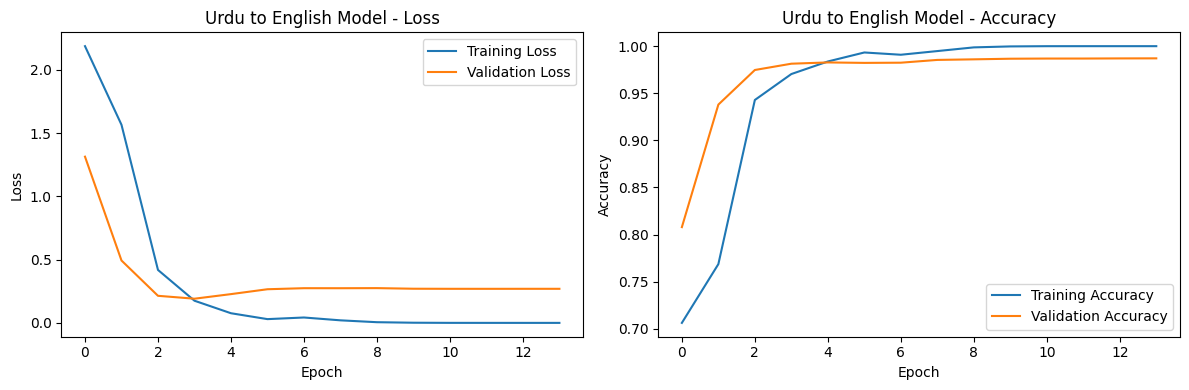

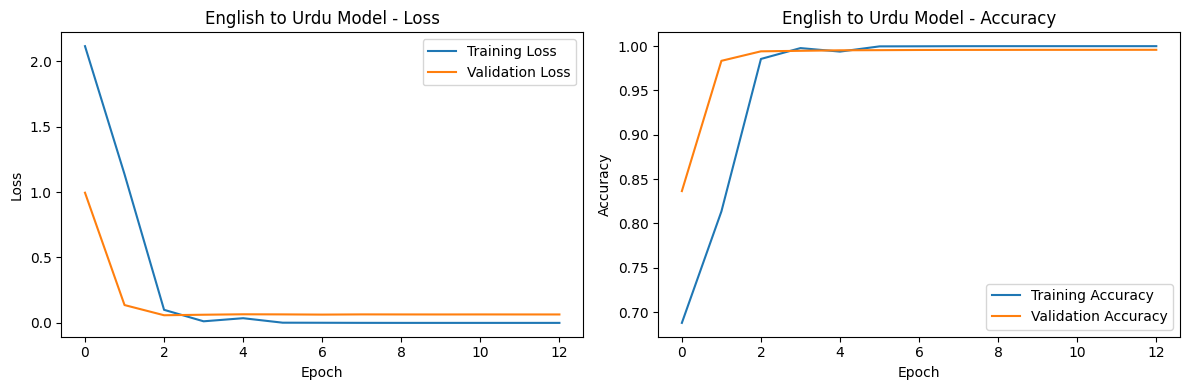

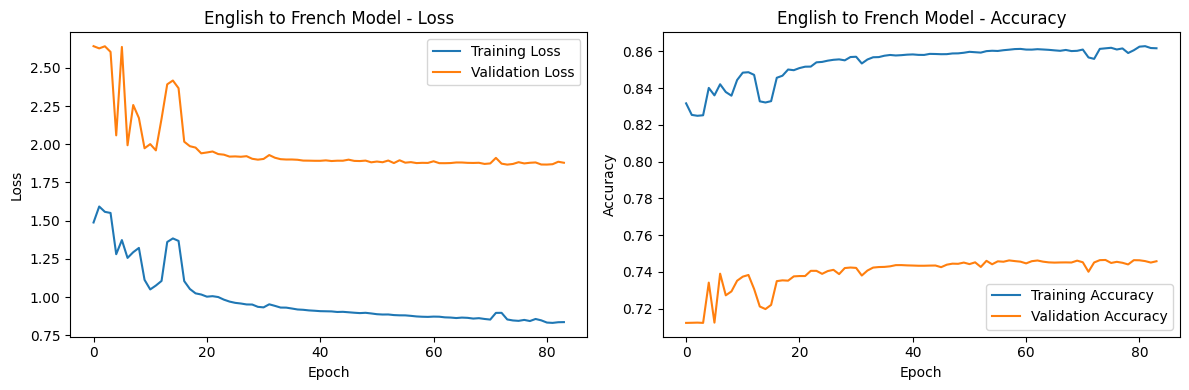

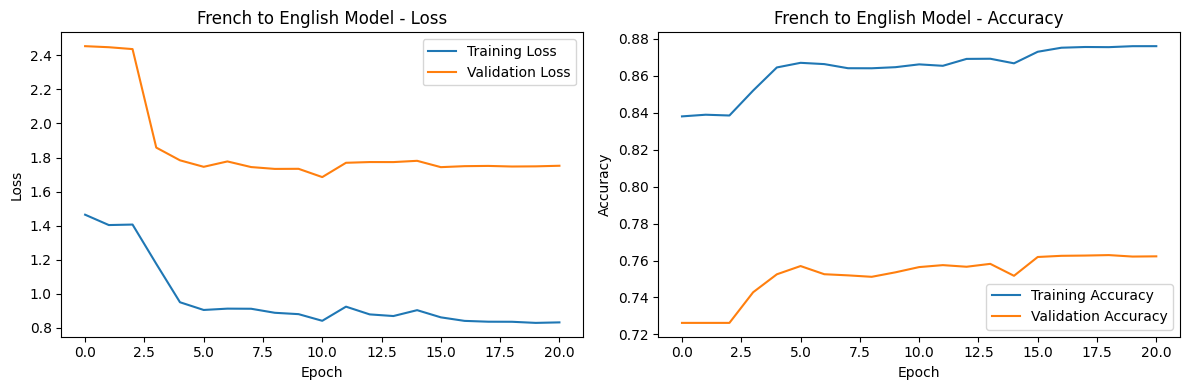

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Translation Example (Urdu to French):
Urdu: آپ کیسے ہیں؟
English: thnx <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>
French: dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans dans
An error occurred during training: File not found: filepath=/kaggle/working/french_english_model.keras. Please ensure the file is an accessible `.keras` zip file.


ValueError: File not found: filepath=/kaggle/working/french_english_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [6]:
# ## Main Training Code
if __name__ == "__main__":
    try:
        # Load and preprocess data
        print("Loading datasets...")
        urdu_english_data = pd.read_excel('/kaggle/input/urdu-eng-french-final-dataset/urdu_eng_dataset.xlsx')
        english_french_data = pd.read_csv('/kaggle/input/urdu-eng-french-final-dataset/eng_french_dataset.csv')

        print("Validating data...")
        urdu_english_data = urdu_english_data.dropna()
        english_french_data = english_french_data.dropna()

        urdu_english_data = urdu_english_data[urdu_english_data['urdu'].str.strip() != '']
        urdu_english_data = urdu_english_data[urdu_english_data['english'].str.strip() != '']
        english_french_data = english_french_data[english_french_data['english'].str.strip() != '']
        english_french_data = english_french_data[english_french_data['french'].str.strip() != '']

        # Extract texts
        urdu_texts = urdu_english_data['urdu'].values
        english_texts_urdu = urdu_english_data['english'].values
        english_texts_french = english_french_data['english'].values
        french_texts = english_french_data['french'].values

        # Train Urdu to English model
        print("\nTraining Urdu to English model...")
        urdu_english_model = UrduToEnglishTranslator()
        urdu_english_history = urdu_english_model.train(urdu_texts, english_texts_urdu)

        # Train English to Urdu model
        print("\nTraining English to Urdu model...")
        english_urdu_model = UrduToEnglishTranslator()
        english_urdu_history = english_urdu_model.train(english_texts_urdu, urdu_texts)

        # Train English to French model
        print("\nTraining English to French model...")
        english_french_model = TransformerTranslator()
        english_french_history = english_french_model.train(english_texts_french, french_texts)

        # Train French to English model
        print("\nTraining French to English model...")
        french_english_model = TransformerTranslator()
        french_english_history = french_english_model.train(french_texts, english_texts_french)

        # Plot training history
        plot_training_history(urdu_english_history, 'Urdu to English Model')
        plot_training_history(english_urdu_history, 'English to Urdu Model')
        plot_training_history(english_french_history, 'English to French Model')
        plot_training_history(french_english_history, 'French to English Model')

        # Example usage
        urdu_text = "آپ کیسے ہیں؟"
        english_text, french_text = translate_urdu_to_french(urdu_text)
        print(f"\nTranslation Example (Urdu to French):")
        print(f"Urdu: {urdu_text}")
        print(f"English: {english_text}")
        print(f"French: {french_text}")

        french_text = "Comment allez-vous?"
        english_text, urdu_text = translate_french_to_urdu(french_text)
        print(f"\nTranslation Example (French to Urdu):")
        print(f"French: {french_text}")
        print(f"English: {english_text}")
        print(f"Urdu: {urdu_text}")

    except Exception as e:
        print(f"An error occurred during training: {str(e)}")
        raise

In [1]:
# ## Model Loading and Translation Example
def load_and_translate(urdu_text):
    # Initialize models
    urdu_english_model = UrduToEnglishTranslator()
    english_french_model = TransformerTranslator()
    
    # Load models
    if not urdu_english_model.load_model():
        print("Error: Urdu to English model not found. Please train the model first.")
        return None, None
    if not english_french_model.load_model():
        print("Error: English to French model not found. Please train the model first.")
        return None, None
    
    # Translate
    english_text, french_text = translate_urdu_to_french(urdu_text)
    return english_text, french_text

# Example usage of loaded models
if __name__ == "__main__":
    urdu_text = "آپ کیسے ہیں؟"
    english_text, french_text = load_and_translate(urdu_text)
    if english_text and french_text:
        print(f"\nTranslation using loaded models:")
        print(f"Urdu: {urdu_text}")
        print(f"English: {english_text}")
        print(f"French: {french_text}") # ## Model Loading and Translation Example
def load_and_translate(urdu_text):
    # Initialize models
    urdu_english_model = UrduToEnglishTranslator()
    english_french_model = TransformerTranslator()
    
    # Load models
    if not urdu_english_model.load_model():
        print("Error: Urdu to English model not found. Please train the model first.")
        return None, None
    if not english_french_model.load_model():
        print("Error: English to French model not found. Please train the model first.")
        return None, None
    
    # Translate
    english_text, french_text = translate_urdu_to_french(urdu_text)
    return english_text, french_text

# Example usage of loaded models
if __name__ == "__main__":
    urdu_text = "آپ کیسے ہیں؟"
    english_text, french_text = load_and_translate(urdu_text)
    if english_text and french_text:
        print(f"\nTranslation using loaded models:")
        print(f"Urdu: {urdu_text}")
        print(f"English: {english_text}")
        print(f"French: {french_text}") 

NameError: name 'UrduToEnglishTranslator' is not defined

In [2]:
if __name__ == "__main__":
    urdu_text = "آپ کیسے ہیں؟"
    english_text, french_text = load_and_translate(urdu_text)
    if english_text and french_text:
        print(f"\nTranslation using loaded models:")
        print(f"Urdu: {urdu_text}")
        print(f"English: {english_text}")
        print(f"French: {french_text}") 

NameError: name 'UrduToEnglishTranslator' is not defined